In [0]:
!mkdir /root/.kaggle
## Upload the kaggle.json file.
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c plant-seedlings-classification
!unzip test.zip
!unzip train.zip
!rm train.zip test.zip sample_submission.csv.zip

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
import cv2
import math
import itertools


from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


%tensorflow_version 1.x
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adadelta, SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Constants

In [0]:
TRAIN_DIRECTORY = "train"
TEST_DIRECTORY = "test"
IMG_HEIGHT = 70
IMG_WIDTH = 70
CATEGORIES = os.listdir(TRAIN_DIRECTORY)
num_classes = len(CATEGORIES)

FILTER = True

# Data Loading

In [13]:
path_to_all_files = TRAIN_DIRECTORY + '/*/*.png' 
files = glob(path_to_all_files)

trainImg = []
trainLabel = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    trainImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print(trainImg.shape)
print(trainLabel.shape)

(4750, 70, 70, 3)
(4750, 1)


In [0]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i*100])

# Cleaning data

## Background Removing

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [0]:
clearTrainImg = []
for img in trainImg:
    image = sharpen_image(segment_plant(img))
    clearTrainImg.append(image)
    
clearTrainImg = np.asarray(clearTrainImg)

In [0]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i*10])

## Normalize Input & Categorize Labels

In [0]:
if FILTER == False:
  trainImg = trainImg / 255
else:
  trainImg = clearTrainImg / 255


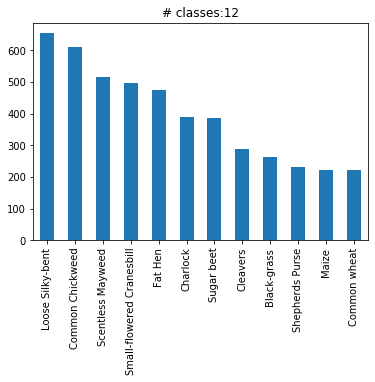

In [17]:
le = preprocessing.LabelEncoder()
encodeTrainLabels = le.fit_transform(trainLabel[0])
clearTrainLabel = to_categorical(encodeTrainLabels)

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar', title="# classes:" + str(clearTrainLabel.shape[1]))


# Model Definition

## Data splitting and Generator

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=33, 
                                                stratify = clearTrainLabel)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X_train)

## Model Architecture

In [21]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', input_shape=(IMG_WIDTH, IMG_WIDTH, 3)))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=64,kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(128))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))


model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(BatchNormalization(axis=-1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 70, 70, 64)        4864      
_________________________________________________________________
batch_normalization_9 (Batch (None, 70, 70, 64)        256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 70, 70, 64)        102464    
_________________________________________________________________
batch_normalization_10 (Batc (None, 70, 70, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 70, 70, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 64)       

In [0]:
# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="weight-cnn-filter.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
filepath="weights-cnn-filter.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

BATCH_SIZE = 16

In [24]:
# fit model
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                           epochs=20,
                           validation_data=(X_valid, y_valid), 
                           steps_per_epoch=(10 * X_train.shape[0]) / BATCH_SIZE,
                           callbacks=[checkpoint, learning_rate_reduction, checkpoint_all])


Epoch 1/20
 950/2375 [===========>..................] - ETA: 1s - loss: 1.4498 - acc: 0.5905
Epoch 00001: val_acc improved from -inf to 0.59053, saving model to weight-cnn-filter.best_01-0.59.hdf5

Epoch 00001: saving model to weights-cnn-filter.last_auto4.hdf5
2375/2375 [==============================] - 79s 33ms/step - loss: 1.1703 - acc: 0.6284 - val_loss: 1.4438 - val_acc: 0.5905
Epoch 2/20
 896/2375 [==========>...................] - ETA: 1s - loss: 0.3796 - acc: 0.8750
Epoch 00002: val_acc improved from 0.59053 to 0.87684, saving model to weight-cnn-filter.best_02-0.88.hdf5

Epoch 00002: saving model to weights-cnn-filter.last_auto4.hdf5
2375/2375 [==============================] - 72s 30ms/step - loss: 0.6868 - acc: 0.7878 - val_loss: 0.3766 - val_acc: 0.8768
Epoch 3/20
 896/2375 [==========>...................] - ETA: 1s - loss: 0.3870 - acc: 0.8705
Epoch 00003: val_acc did not improve from 0.87684

Epoch 00003: saving model to weights-cnn-filter.last_auto4.hdf5
2375/2375 [====

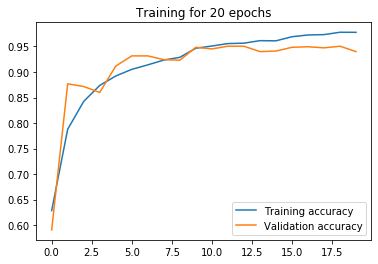

In [25]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Training for ' +str(20)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [26]:
  model.load_weights("weight-cnn-filter.best_12-0.95.hdf5")

print("Train accuracy", model.evaluate(X_train, y_train))  # Evaluate on train set
print("Validation accuracy", model.evaluate(X_valid, y_valid))  # Evaluate on test set

3800/3800 [==============================] - 2s 564us/sample - loss: 0.0699 - acc: 0.9758
Train accuracy [0.0699031253080619, 0.9757895]
950/950 [==============================] - 1s 622us/sample - loss: 0.1340 - acc: 0.9505
Validation accuracy [0.1340311636579664, 0.9505263]


# Confusion Matrix

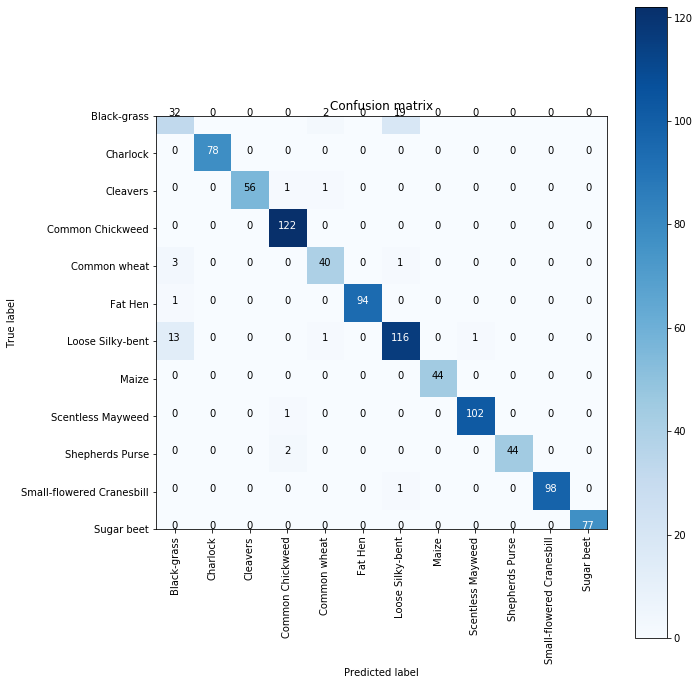

In [27]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_valid, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(y_true, y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 


# Predicting on Test Set

In [28]:
path =  TEST_DIRECTORY + '/*.png'
files = glob(path)

testImg = []
testId = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    testId.append(img.split('/')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))

testImg = np.asarray(testImg)  # Train images set

print(testImg.shape)

(794, 70, 70, 3)


In [0]:
clearTestImg = []
for img in testImg:
    image = sharpen_image(segment_plant(img))
    clearTestImg.append(image)
    
clearTestImg = np.asarray(clearTestImg)

In [0]:
if FILTER == False:
  testImg = testImg / 255
else:
  testImg = clearTestImg / 255


In [0]:
pred = model.predict(testImg)

In [0]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("res.csv", index=False)